In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option("display.max_columns" , 50)

### Read in data

In [15]:
df = pd.read_csv("amp_labels_viv.csv")

### read in covid_lies data

In [16]:
cl = pd.read_csv("covid_lies_sample.csv")

In [17]:
cl.rename(columns={"misconception": "text"}, inplace = True)

In [18]:
# combine with AMP data
df = pd.concat([df, cl], ignore_index=True)

In [19]:
def combine_non_na(row):
    return [value for value in row if pd.notna(value)]

In [20]:
# combine labels
df["labels"] = df[["themeName", "manual_themeName", "manual_themeName2"]].apply(lambda row: combine_non_na(row), axis=1)

## Find which labels are most common

In [21]:
df_counts = df["labels"].explode().value_counts()

In [22]:
df_counts.to_frame().head(8).T

,Vaccine Side Effects,Conspiracy,Vaccine Efficacy,Case Reporting,Home Remedies,Bio-weapon,Vaccine ingredients,Government
labels,19,14,7,6,6,5,3,3


## create an identifier to split if row has label or not

In [23]:
df["labels"] = df["labels"].fillna("")

In [24]:
df["split"] = "unlabeled"
mask = df["labels"].apply(lambda x: len(x)) > 0
df.loc[mask, "split"] = "labeled"

In [25]:
df["split"].value_counts()

unlabeled    65
labeled      60
Name: split, dtype: int64

In [26]:
df.columns

Index(['date', 'attachments', 'textTranslated', 'detectedLanguage',
       'likeCount', 'countries', 'authorId', 'url', 'platform', 'commentCount',
       'socialMediaPostType', 'shareCount', 'createdAt', 'submittedLanguage',
       'themeIds', 'issueIds', 'text', 'updatedAt', 'id', 'index', 'type',
       'issueName', 'themeName', 'manuarl_issueName', 'manual_themeName',
       'manual_themeName2', 'misconception_id', 'tweet_id', 'label', 'labels',
       'split'],
      dtype='object')

### drop duplicates

In [27]:
len_before = len(df)
df = df.drop_duplicates(subset = "text")
print(f"Removed {(len_before - len(df))/len_before:.2%} duplicates.")

Removed 0.00% duplicates.


# Create training sets

In [28]:
from sklearn.preprocessing import MultiLabelBinarizer

MultiLabelBinarizer takes a list of label names and creates a vector with zeros for absent labels and ones for present labels. We can test this by fitting MultiLabelBinarizer on all_labels to learn the mapping from label name to ID

In [29]:
all_labels = list(df["themeName"].unique())

In [30]:
for theme in list(df["manual_themeName"].unique()):
    if theme not in all_labels:
        all_labels.append(theme)

In [31]:
all_labels = [x for x in all_labels if str(x) != 'nan']

In [32]:
mlb = MultiLabelBinarizer()
mlb.fit([all_labels])
mlb.transform([["Bio-weapon", "Vaccine Side Effects"], ["Home Remedies"]])

array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

### Create splits iteratively 

In [33]:
from skmultilearn.model_selection import iterative_train_test_split

def balanced_split(df, test_size=0.5):
    ind = np.expand_dims(np.arange(len(df)), axis=1)
    labels = mlb.transform(df["labels"])
    ind_train, _, ind_test, _ = iterative_train_test_split(ind, labels,
                                                           test_size)
    return df.iloc[ind_train[:, 0]], df.iloc[ind_test[:,0]]

In [34]:
from sklearn.model_selection import train_test_split

df_clean = df[["text", "labels", "split"]].reset_index(drop=True).copy()

# unsupervised set
df_unsup = df_clean.loc[df_clean["split"] == "unlabeled", ["text", "labels"]]

# supervised set
df_sup = df_clean.loc[df_clean["split"] == "labeled", ["text", "labels"]]

np.random.seed(0)
df_train, df_tmp = balanced_split(df_sup, test_size=0.5)
df_valid, df_test = balanced_split(df_tmp, test_size=0.5)

/opt/conda/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) ['Bio-Weapon', 'Vaccine ingredient', 'Vaccine ingredients'] will be ignored
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) ['Bio-Weapon', 'Vaccine ingredients'] will be ignored
  warnings.warn(


### Create a dataset so all these splits are in one

In [35]:
from datasets import Dataset, DatasetDict

ds = DatasetDict({
    "train": Dataset.from_pandas(df_train.reset_index(drop=True)),
    "valid": Dataset.from_pandas(df_valid.reset_index(drop=True)),
    "test": Dataset.from_pandas(df_test.reset_index(drop=True)),
    "unsup": Dataset.from_pandas(df_unsup.reset_index(drop=True))})


### Create training slides to investigate what's the right balance of supervised to unsupervised data needed

In [36]:
np.random.seed(0)
all_indices = np.expand_dims(list(range(len(ds["train"]))), axis=1)
indices_pool = all_indices
labels = mlb.transform(ds["train"]["labels"])
train_samples = [8, 16, 32]
train_slices, last_k = [], 0

for i, k in enumerate(train_samples):
    # Split off samples necessary to fill the gap to the next split size
    indices_pool, labels, new_slice, _ = iterative_train_test_split(
        indices_pool, labels, (k-last_k)/len(labels))
    last_k = k
    if i==0: train_slices.append(new_slice)
    else: train_slices.append(np.concatenate((train_slices[-1], new_slice)))

/opt/conda/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) ['Vaccine ingredient', 'Vaccine ingredients'] will be ignored
  warnings.warn(


In [37]:
# Add full dataset as last slice
train_slices.append(all_indices), train_samples.append(len(ds["train"]))


(None, None)

In [38]:
train_slices = [np.squeeze(train_slice) for train_slice in train_slices]

In [39]:
train_slices

[array([ 0,  2,  4,  6, 11, 14, 16, 18]),
 array([ 0,  2,  4,  6, 11, 14, 16, 18,  1,  3,  7, 12, 15, 19, 26, 27]),
 array([ 0,  2,  4,  6, 11, 14, 16, 18,  1,  3,  7, 12, 15, 19, 26, 27,  5,
         8,  9, 10, 13, 17, 20, 21, 22, 23, 24, 25, 28, 29]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])]

In [40]:
print("Target split sizes:")
print(train_samples)
print("Actual split sizes:")
print([len(x) for x in train_slices])

Target split sizes:
[8, 16, 32, 30]
Actual split sizes:
[8, 16, 30, 30]


## Create Naive Bayesline

In [41]:
def prepare_labels(batch):
    batch["label_ids"] = mlb.transform(batch["labels"])
    return batch

ds = ds.map(prepare_labels, batched=True)

Map:   0%|          | 0/30 [00:00<?, ? examples/s]

Map:   0%|          | 0/18 [00:00<?, ? examples/s]

/opt/conda/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) ['Vaccine ingredients'] will be ignored
  warnings.warn(


Map:   0%|          | 0/12 [00:00<?, ? examples/s]

Map:   0%|          | 0/65 [00:00<?, ? examples/s]

In [42]:
from collections import defaultdict

macro_scores, micro_scores = defaultdict(list), defaultdict(list)


### Train baseline

In [43]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.feature_extraction.text import CountVectorizer

for train_slice in train_slices:
    # Get training slice and test data
    ds_train_sample = ds["train"].select(train_slice)
    y_train = np.array(ds_train_sample["label_ids"])
    y_test = np.array(ds["test"]["label_ids"])
    # Use a simple count vectorizer to encode our texts as token counts
    count_vect = CountVectorizer()
    X_train_counts = count_vect.fit_transform(ds_train_sample["text"])
    X_test_counts = count_vect.transform(ds["test"]["text"])
    # Create and train our model!
    classifier = BinaryRelevance(classifier=MultinomialNB())
    classifier.fit(X_train_counts, y_train)
    # Generate predictions and evaluate
    y_pred_test = classifier.predict(X_test_counts)
    clf_report = classification_report(
        y_test, y_pred_test, target_names=mlb.classes_, zero_division=0,
        output_dict=True)
    # Store metrics
    macro_scores["Naive Bayes"].append(clf_report["macro avg"]["f1-score"])
    micro_scores["Naive Bayes"].append(clf_report["micro avg"]["f1-score"])

In [44]:
import matplotlib.pyplot as plt

def plot_metrics(micro_scores, macro_scores, sample_sizes, current_model):
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

    for run in micro_scores.keys():
        if run == current_model:
            ax0.plot(sample_sizes, micro_scores[run], label=run, linewidth=2)
            ax1.plot(sample_sizes, macro_scores[run], label=run, linewidth=2)
        else:
            ax0.plot(sample_sizes, micro_scores[run], label=run,
                     linestyle="dashed")
            ax1.plot(sample_sizes, macro_scores[run], label=run,
                     linestyle="dashed")

    ax0.set_title("Micro F1 scores")
    ax1.set_title("Macro F1 scores")
    ax0.set_ylabel("Test set F1 score")
    ax0.legend(loc="lower right")
    for ax in [ax0, ax1]:
        ax.set_xlabel("Number of training samples")
        ax.set_xscale("log")
        ax.set_xticks(sample_sizes)
        ax.set_xticklabels(sample_sizes)
        ax.minorticks_off()
    plt.tight_layout()
    plt.show()

## Plot baseline

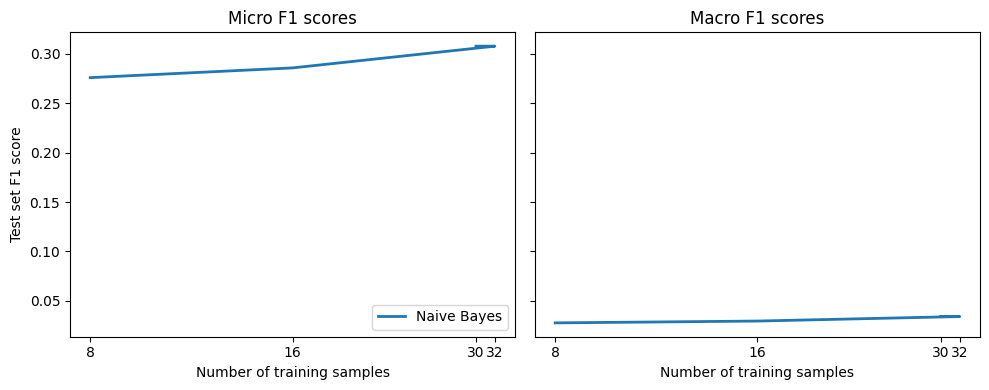

In [231]:
plot_metrics(micro_scores, macro_scores, train_samples, "Naive Bayes")


Note that we plot the number of samples on a logarithmic scale. From the figure we can see that the micro and macro F1-scores both improve as we increase the number of training samples. With so few samples to train on, the results are also slightly noisy since each slice can have a different class distribution. Nevertheless, what’s important here is the trend, so let’s now see how these results fare against transformer-based approaches!

# Use embeddings as a lookup table

In [45]:
import torch
from transformers import AutoTokenizer, AutoModel

In [46]:
model_ckpt = "miguelvictor/python-gpt2-large"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModel.from_pretrained(model_ckpt)

def mean_pooling(model_output, attention_mask):
    # Extract the token embeddings
    token_embeddings = model_output[0]
    # Compute the attention mask
    input_mask_expanded = (attention_mask
                           .unsqueeze(-1)
                           .expand(token_embeddings.size())
                           .float())
    # Sum the embeddings, but ignore masked tokens
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    # Return the average as a single vector
    return sum_embeddings / sum_mask

def embed_text(examples):
    inputs = tokenizer(examples["text"], padding=True, truncation=True,
                       max_length=128, return_tensors="pt")
    with torch.no_grad():
        model_output = model(**inputs)
    pooled_embeds = mean_pooling(model_output, inputs["attention_mask"])
    return {"embedding": pooled_embeds.cpu().numpy()}

Some weights of the model checkpoint at miguelvictor/python-gpt2-large were not used when initializing GPT2Model: ['lm_head.weight']
- This IS expected if you are initializing GPT2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Get embedding for each split

In [17]:
tokenizer.pad_token = tokenizer.eos_token


In [20]:
train = df[df["split"] == "labeled"]

In [234]:
tokenizer.pad_token = tokenizer.eos_token
embs_train = ds["train"].map(embed_text, batched=True, batch_size=16)
embs_valid = ds["valid"].map(embed_text, batched=True, batch_size=16)
embs_test = ds["test"].map(embed_text, batched=True, batch_size=16)

Map:   0%|          | 0/30 [00:00<?, ? examples/s]

Map:   0%|          | 0/18 [00:00<?, ? examples/s]

Map:   0%|          | 0/12 [00:00<?, ? examples/s]

## Write to pickle to save

In [1]:
import pickle

In [236]:
train_file = open("amp_embs_train", "ab")
valid_file = open("amp_embs_valid", "ab")
test_file = open("amp_embs_test", "ab")

In [237]:
pickle.dump(embs_train, train_file)
pickle.dump(embs_valid, valid_file)
pickle.dump(embs_test, test_file)

### For when we want to load data back in

In [2]:
train_file = open("amp_embs_train", "rb")
valid_file = open("amp_embs_valid", "rb")
test_file = open("amp_embs_test", "rb")


In [3]:
embs_train = pickle.load(train_file)
embs_valid = pickle.load(valid_file)
embs_test = pickle.load(test_file)

train_file = open("embs_train", "rb")
valid_file = open("embs_valid", "rb")
test_file = open("embs_test", "rb")
embs_train = pickle.load(train_file)
embs_valid = pickle.load(valid_file)
embs_test = pickle.load(test_file)

## Install Faiss

In [4]:
pip install faiss-gpu


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [5]:
import faiss

### Add embedding index

In [6]:
embs_train.add_faiss_index("embedding")

  0%|          | 0/1 [00:00<?, ?it/s]

Dataset({
    features: ['text', 'labels', 'label_ids', 'embedding'],
    num_rows: 30
})

## Perform nearest neighbor lookup

We need to specify the query embedding as well as the number of nearest neighbors to retrieve. Let’s give it a spin and have a look at the documents that are closest to an example:

In [9]:
i, k = 0, 3 # Select the first query and 3 nearest neighbors
rn, nl = "\r\n\r\n", "\n" # Used to remove newlines in text for compact display

query =  np.array(embs_valid[i]["embedding"], dtype=np.float32)
scores, samples = embs_train.get_nearest_examples("embedding", query, k=k)

print(f"QUERY LABELS: {embs_valid[i]['labels']}")
print(f"QUERY TEXT:\n{embs_valid[i]['text'][:200].replace(rn, nl)} [...]\n")
print("="*50)
print(f"Retrieved documents:")
for score, label, text in zip(scores, samples["labels"], samples["text"]):
    print("="*50)
    print(f"TEXT:\n{text[:200].replace(rn, nl)} [...]")
    print(f"SCORE: {score:.2f}")
    print(f"LABELS: {label}")

QUERY LABELS: ['Case Reporting']
QUERY TEXT:
rumors of a new outbreak of covid in tanzania ummy makes a statement we are processing information [...]

Retrieved documents:
TEXT:
hi alai im a practitioner at a certain govt hospital in kisumu please hide my identity over the past 3weeks i have diagonised dozen of patients with similar symptoms akin to that of covid 19 but has m [...]
SCORE: 121.60
LABELS: ['Variants', 'Case Reporting']
TEXT:
thekeksociety nobel prize winner found dead after exposing hiv in the covid vaccines [...]
SCORE: 124.68
LABELS: ['Vaccine Side Effects', 'Conspiracy', 'Vaccine ingredient']
TEXT:
in uganda they were injecting people with water for covid vaccine [...]
SCORE: 126.18
LABELS: ['Conspiracy']


## Find what's the best k value

In [47]:
def get_sample_preds(sample, m):
    return (np.sum(sample["label_ids"], axis=0) >= m).astype(int)

def find_best_k_m(ds_train, valid_queries, valid_labels, max_k=17):
    max_k = min(len(ds_train), max_k)
    perf_micro = np.zeros((max_k, max_k))
    perf_macro = np.zeros((max_k, max_k))
    for k in range(1, max_k):
        for m in range(1, k + 1):
            _, samples = ds_train.get_nearest_examples_batch("embedding",
                                                             valid_queries, k=k)
            y_pred = np.array([get_sample_preds(s, m) for s in samples])
            clf_report = classification_report(valid_labels, y_pred,
                target_names=mlb.classes_, zero_division=0, output_dict=True)
            perf_micro[k, m] = clf_report["micro avg"]["f1-score"]
            perf_macro[k, m] = clf_report["macro avg"]["f1-score"]
    return perf_micro, perf_macro

In [48]:
valid_labels = np.array(embs_valid["label_ids"])
valid_queries = np.array(embs_valid["embedding"], dtype=np.float32)
perf_micro, perf_macro = find_best_k_m(embs_train, valid_queries, valid_labels)


k = number of neighbors
m = assign all labels that occurred at least m times (m < k)

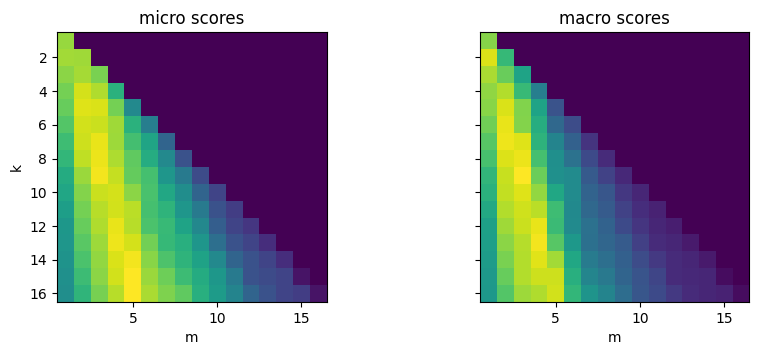

In [42]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 3.5), sharey=True)
ax0.imshow(perf_micro)
ax1.imshow(perf_macro)

ax0.set_title("micro scores")
ax0.set_ylabel("k")
ax1.set_title("macro scores")
for ax in [ax0, ax1]:
    ax.set_xlim([0.5, 17 - 0.5])
    ax.set_ylim([17 - 0.5, 0.5])
    ax.set_xlabel("m")
plt.show()

In [43]:
k, m = np.unravel_index(perf_micro.argmax(), perf_micro.shape)
print(f"Best k: {k}, best m: {m} The perfomance is best when we choose and, or in other words when we retrieve the 4 nearest neighbors and then assign the labels that occurred at least 2 times.")

Best k: 4, best m: 2 The perfomance is best when we choose and, or in other words when we retrieve the 4 nearest neighbors and then assign the labels that occurred at least 2 times.


## Remove the fiass embedding so we can compare to NB

In [38]:
embs_train.drop_index("embedding")
test_labels = np.array(embs_test["label_ids"])
test_queries = np.array(embs_test["embedding"], dtype=np.float32)

for train_slice in train_slices:
    # Create a Faiss index from training slice
    embs_train_tmp = embs_train.select(train_slice)
    embs_train_tmp.add_faiss_index("embedding")
    # Get best k, m values with validation set
    perf_micro, _ = find_best_k_m(embs_train_tmp, valid_queries, valid_labels)
    k, m = np.unravel_index(perf_micro.argmax(), perf_micro.shape)
    # Get predictions on test set
    _, samples = embs_train_tmp.get_nearest_examples_batch("embedding",
                                                           test_queries,
                                                           k=int(k))
    y_pred = np.array([get_sample_preds(s, m) for s in samples])
    # Evaluate predictions
    clf_report = classification_report(test_labels, y_pred,
        target_names=mlb.classes_, zero_division=0, output_dict=True,)
    macro_scores["Embedding"].append(clf_report["macro avg"]["f1-score"])
    micro_scores["Embedding"].append(clf_report["micro avg"]["f1-score"])

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

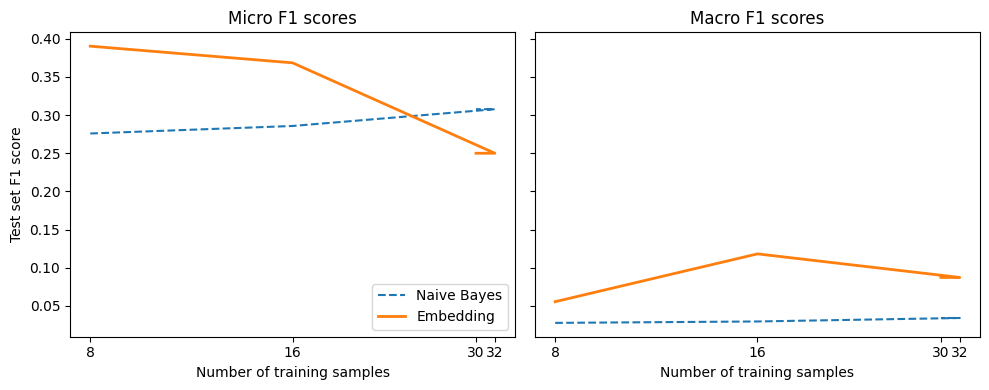

In [42]:
plot_metrics(micro_scores, macro_scores, train_samples, "Embedding")


## Run embedding preds on all the data

In [ ]:
for train_slice in train_slices:
    # Create a Faiss index from training slice
    embs_train_tmp = embs_train.select(train_slice)
    embs_train_tmp.add_faiss_index("embedding")
    # Get best k, m values with validation set
    perf_micro, _ = find_best_k_m(embs_train_tmp, valid_queries, valid_labels)
    k, m = np.unravel_index(perf_micro.argmax(), perf_micro.shape)
    # Get predictions on test set
    _, samples = embs_train_tmp.get_nearest_examples_batch("embedding",
                                                           test_queries,
                                                           k=int(k))
    y_pred = np.array([get_sample_preds(s, m) for s in samples])
    # Evaluate predictions
    clf_report = classification_report(test_labels, y_pred,
        target_names=mlb.classes_, zero_division=0, output_dict=True,)
    macro_scores["Embedding"].append(clf_report["macro avg"]["f1-score"])
    micro_scores["Embedding"].append(clf_report["micro avg"]["f1-score"])

In [44]:
embs_train

Dataset({
    features: ['text', 'labels', 'label_ids', 'embedding'],
    num_rows: 30
})

array([ 0,  2,  4,  6, 11, 14, 16, 18])

In [47]:
embs_train_tmp = embs_train.select(train_slices[0])

In [48]:
embs_train_tmp.add_faiss_index("embedding")

  0%|          | 0/1 [00:00<?, ?it/s]

Dataset({
    features: ['text', 'labels', 'label_ids', 'embedding'],
    num_rows: 8
})

In [49]:
perf_micro, _ = find_best_k_m(embs_train_tmp, valid_queries, valid_labels)
k, m = np.unravel_index(perf_micro.argmax(), perf_micro.shape)

In [57]:
_, samples = embs_train_tmp.get_nearest_examples_batch("embedding",
                                                           test_queries,
                                                           k=int(4))

In [58]:
y_pred = np.array([get_sample_preds(s, 2) for s in samples])

In [59]:
y_pred

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]])